In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import cv2 as cv

In [2]:
os.listdir()

['pyproject.toml',
 'tests',
 'README.md',
 '.gitignore',
 '.env',
 '.ipynb_checkpoints',
 'poetry.lock',
 '.git',
 'pbn',
 'image_processing_sandbox.ipynb',
 'opencv_image_processing_sandbox.ipynb',
 '.idea']

In [3]:
def show_img(images, titles=None):
    if type(images) != type([]):
        raise ValueError("input `images` must be a list of images")
    n = len(images)
    fig, ax = plt.subplots(n, 1, figsize=(16, 9 * n))
    if n == 1:
        ax = [ax]
    for i in range(n):
        a = ax[i]
        img = images[i]
        if len(img.shape) == 3:         
            # switch bgr to rgb
            #b,g,r = cv.split(img) # get b,g,r
            #img = cv.merge([r,g,b]) # switch it to rgb
            a.imshow(img)
        
        else:
            #grayscale
            a.imshow(img, cmap='gray')
            
        if titles:
            a.set_title(titles[i])
        a.axis('off')
    plt.show()

In [4]:
img = cv.imread("./tests/unit/data/thumbnails/armadaugs_1653850939.png")

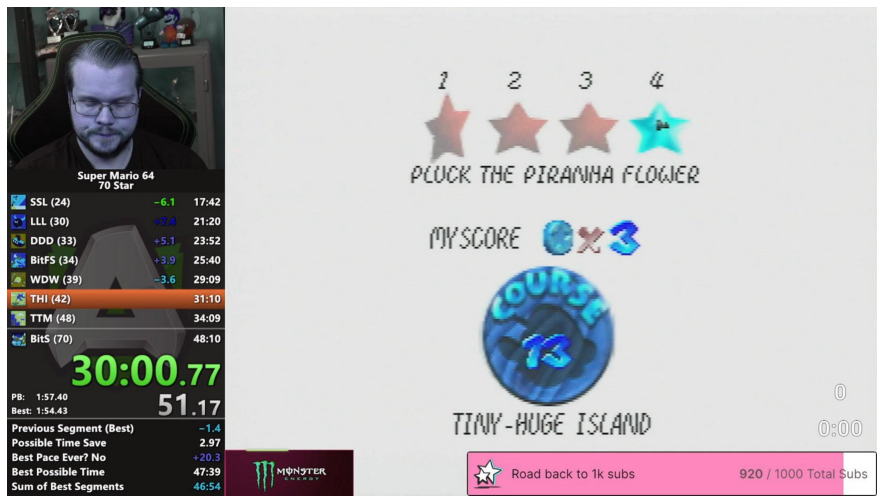

In [5]:
show_img([img])

# Enhancing the image for text extraction with opencv

# CLAHE - Contrast Limited Adaptive Histogram Equalization

In [6]:
def clahe(img, clipLimit=2.0, tileGridSize=(4,4)):
    # converting to LAB color space
    lab= cv.cvtColor(img, cv.COLOR_BGR2LAB)
    l_channel, a, b = cv.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    return cv.cvtColor(limg, cv.COLOR_LAB2BGR)

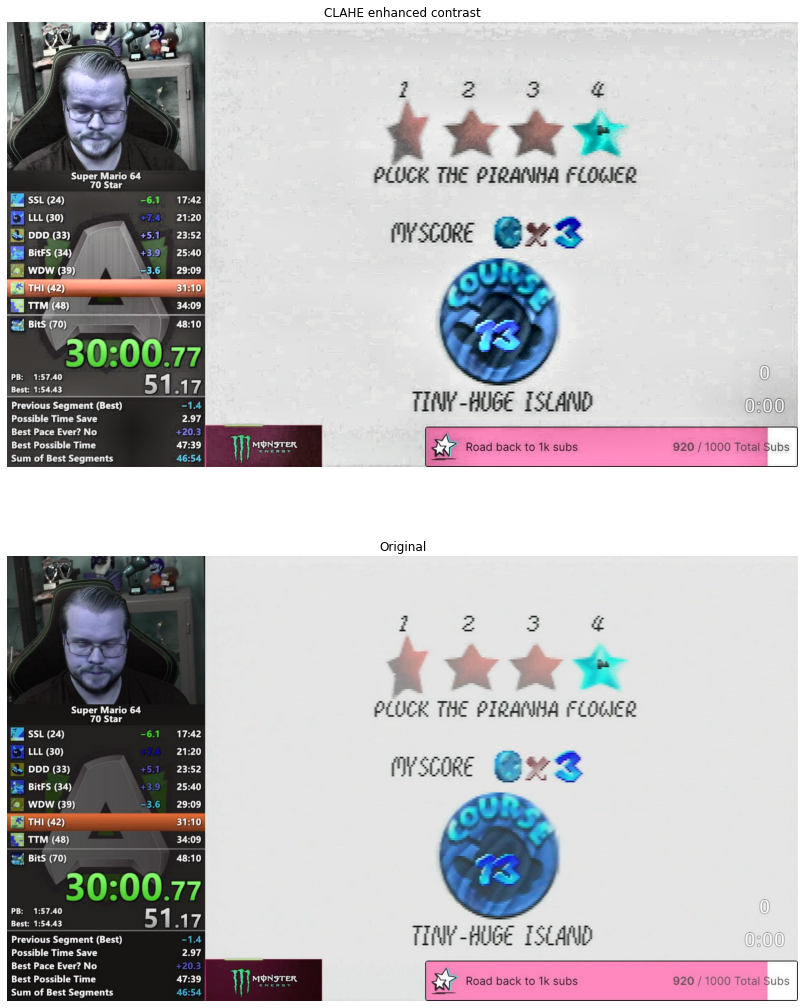

In [246]:
img_clahe = clahe(img, 4, (16, 16))

show_img(
    [img_clahe, img], 
    titles=["CLAHE enhanced contrast", "Original"]
)

# grayscale

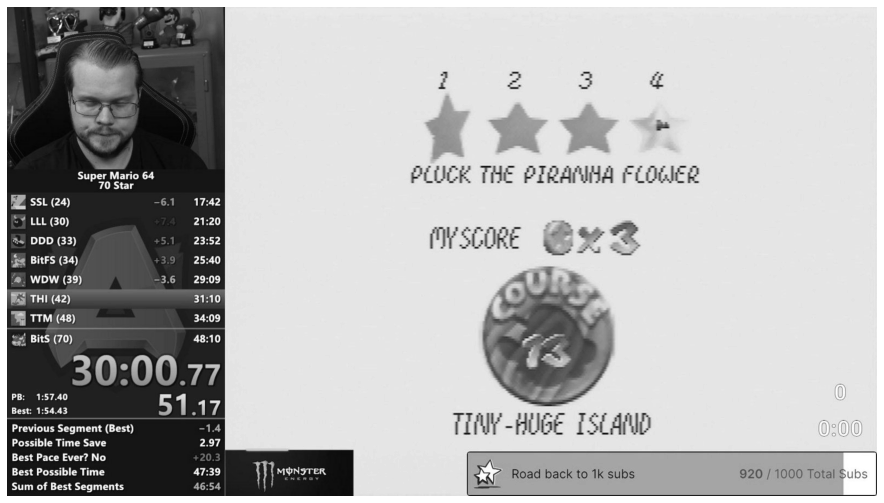

In [8]:
def to_grayscale(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

show_img([to_grayscale(img)])

# thresholding

In [9]:
def threshold(img, th):
    _, th = cv.threshold(to_grayscale(img),th,255,cv.THRESH_BINARY)
    return th

def threshold_tozero(img, th):
    _, th = cv.threshold(to_grayscale(img),th,255,cv.THRESH_TOZERO)
    return th

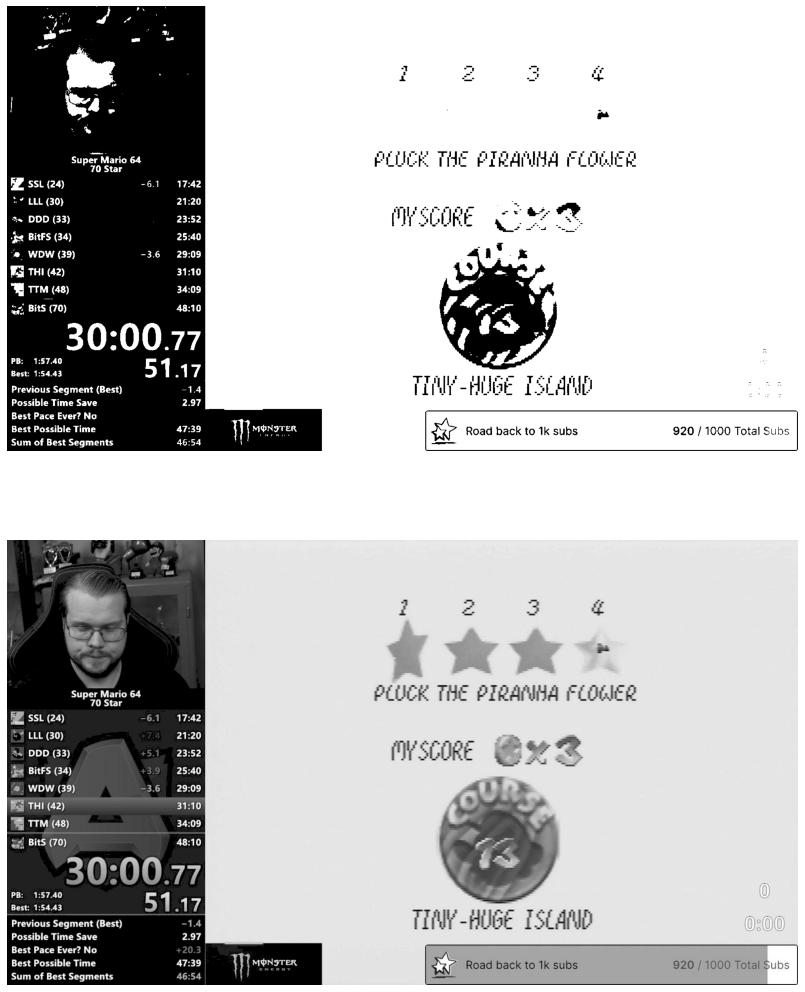

In [10]:
show_img([threshold(img, 130), threshold_tozero(img, 30)])

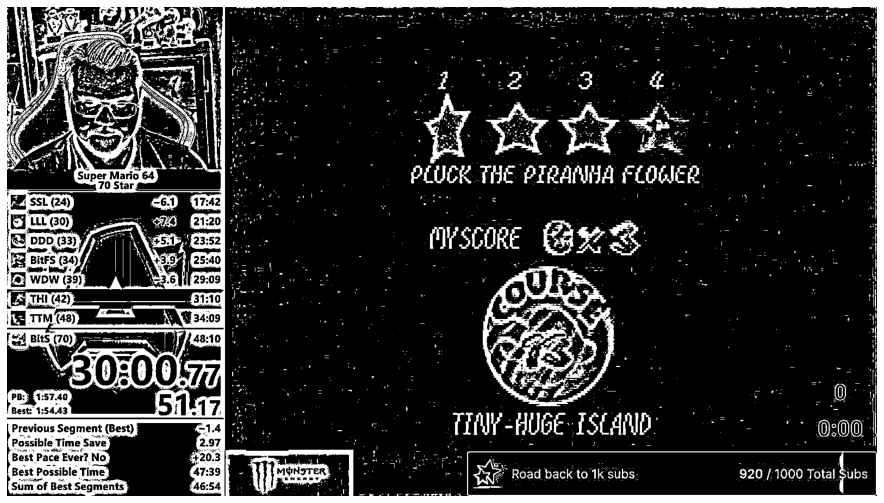

In [11]:
show_img([cv.adaptiveThreshold(
    src=to_grayscale(img),
    maxValue=255,
    adaptiveMethod=cv.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv.THRESH_BINARY_INV,
    blockSize=21,
    C=2
)])

# Morphological Transformations

In [251]:
img_base = to_grayscale(img.copy())

erosion = cv.erode(img_base,kernel=np.ones((4,2),np.uint8),iterations = 1)
dilation = cv.dilate(img_base,kernel=np.ones((4,2),np.uint8),iterations = 1)
closing = cv.erode(dilation,kernel=np.ones((4,2),np.uint8),iterations = 1)

In [252]:
show_img(
    [img_base, erosion, dilation, closing],
    ["Base", "Erosion", "Dilation", "Closing"]
)

# HSV - Hue Saturation Value

On output 0≤V≤1, 0≤S≤1, 0≤H≤360 .


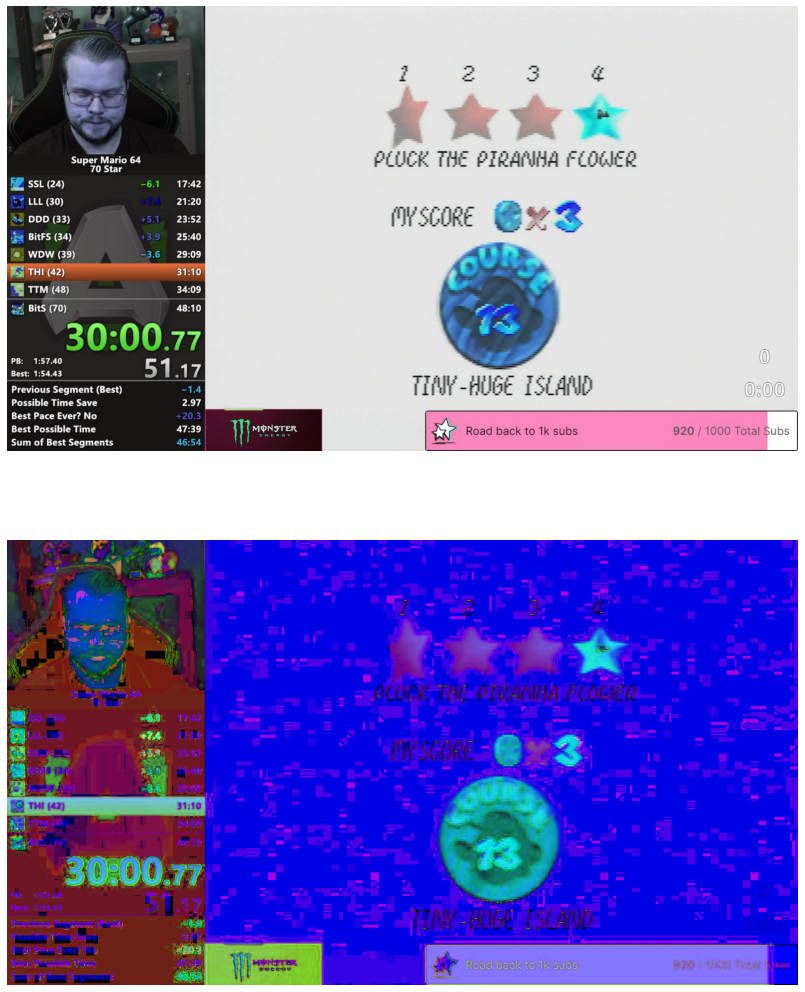

In [63]:
def to_hsv(im):
    return cv.cvtColor(im, cv.COLOR_BGR2HSV)

def to_bgr(im):
    return cv.cvtColor(im, cv.COLOR_HSV2BGR)

show_img([img, to_hsv(img)])

In [121]:
# detect black  -> low value
_ = cv.inRange(to_hsv(img), np.array([0, 0, 0],np.uint8), np.array([179, 255, 25],np.uint8))
show_img([_])

In [140]:
# detect white -> low saturation, high value
_ = cv.inRange(to_hsv(img), np.array([0, 0, 200],np.uint8), np.array([179, 50, 255],np.uint8))
show_img([_])

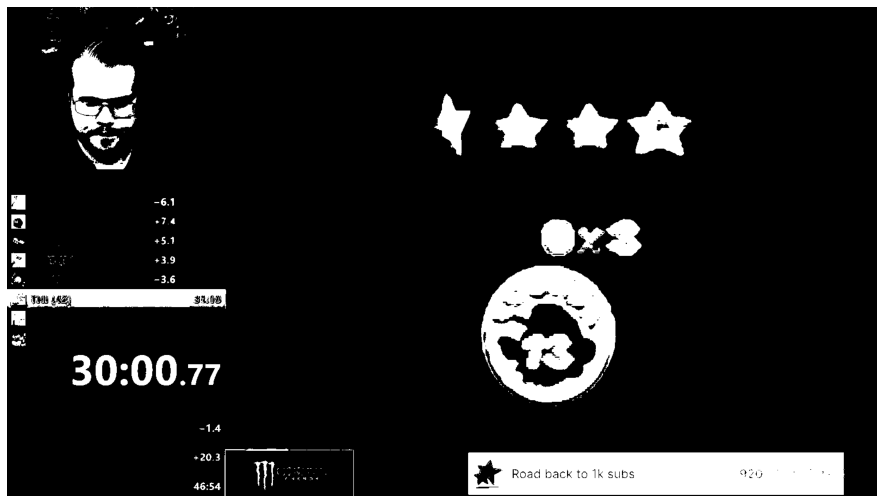

In [156]:
# detect color -> high saturation, high value
_ = cv.inRange(to_hsv(img), np.array([0, 25, 125],np.uint8), np.array([179, 255, 255],np.uint8))
show_img([_])

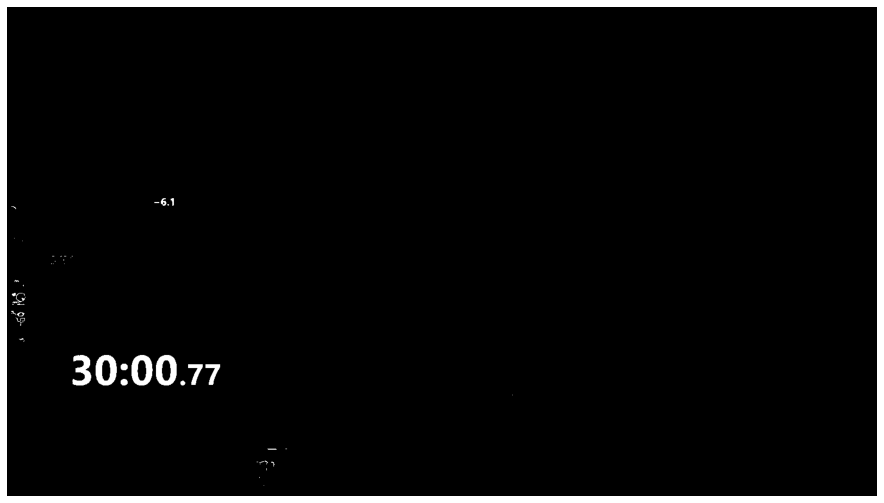

In [157]:
# detect green

_ = cv.inRange(to_hsv(img), np.array([50, 25, 125],np.uint8), np.array([70, 255, 255],np.uint8))
show_img([_])

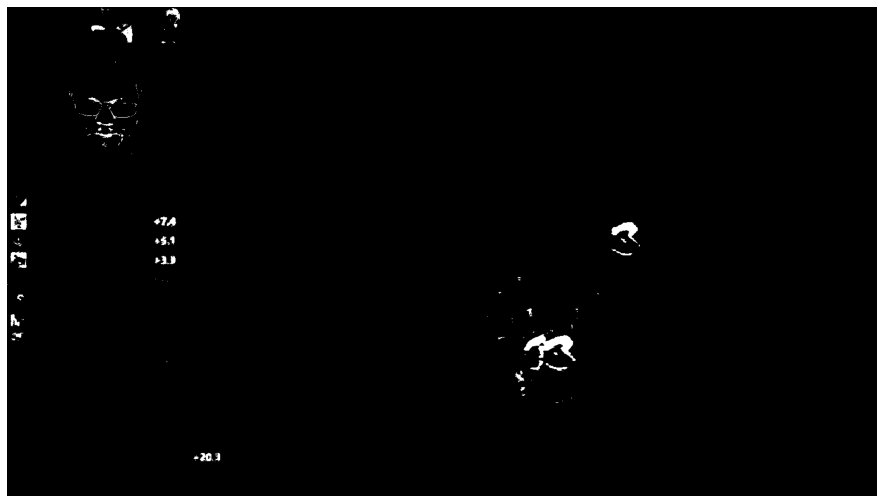

In [165]:
# detect red

_ = (cv.inRange(
    to_hsv(img), np.array([0, 100, 50],np.uint8), np.array([10, 255, 255],np.uint8)
    ) | (cv.inRange(
    to_hsv(img), np.array([160, 100, 50],np.uint8), np.array([179, 255, 255],np.uint8)
    )
    ))
show_img([_])

# Inverting

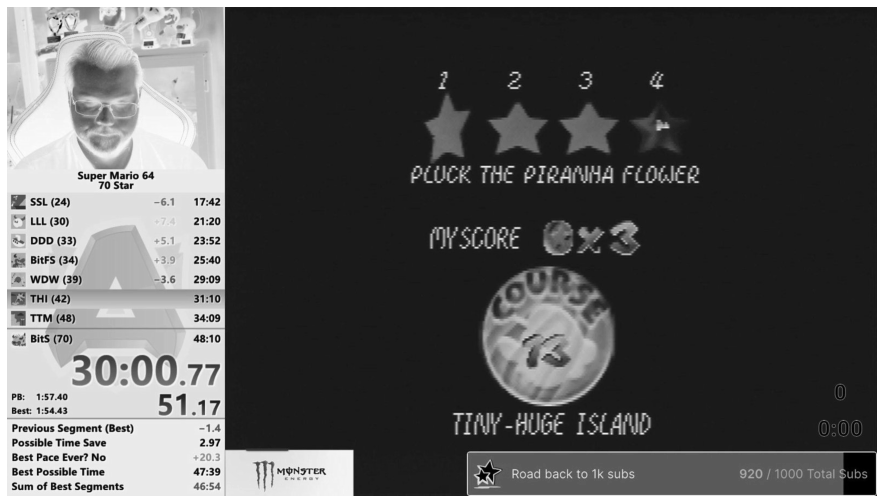

In [242]:
show_img([cv.bitwise_not(to_grayscale(img))])

# Manual stuff

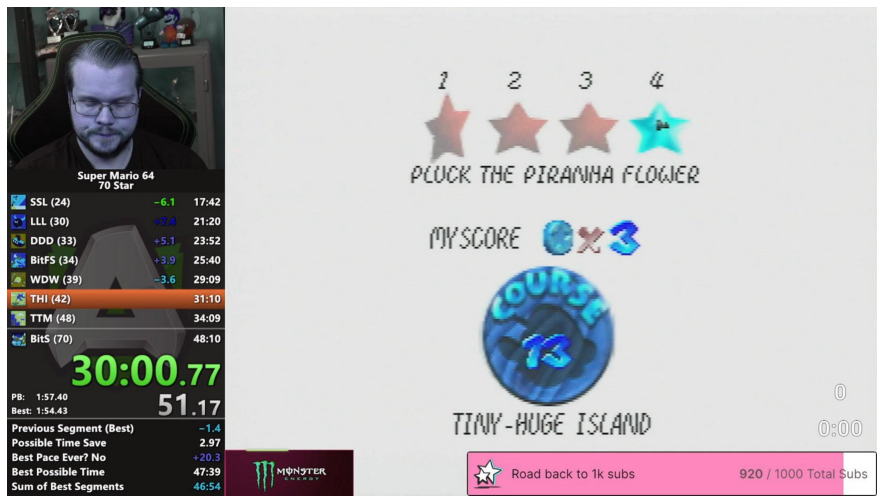

CPU times: user 534 ms, sys: 57.1 ms, total: 591 ms
Wall time: 362 ms


In [221]:
%%time

def red_to_white(a):
    if a[0] > 100:
        return a + a[0]
    elif a[1] > 100:
        return a + a[1]
    else:
        return a

def bump_splits(im):
    b,g,r = cv.split(im) # get b,g,r
    b,g,r= b.astype("int"), g.astype("int"), r.astype("int")
    
    img = cv.merge([b.clip(max=255).astype("uint8"), g.clip(max=255).astype("uint8"), r.clip(max=255).astype("uint8")]) # switch it to rgb
    #pix = np.apply_along_axis(red_to_white, 2, im).clip(max=255).astype("uint8")
    return img

show_img([bump_splits(img)])

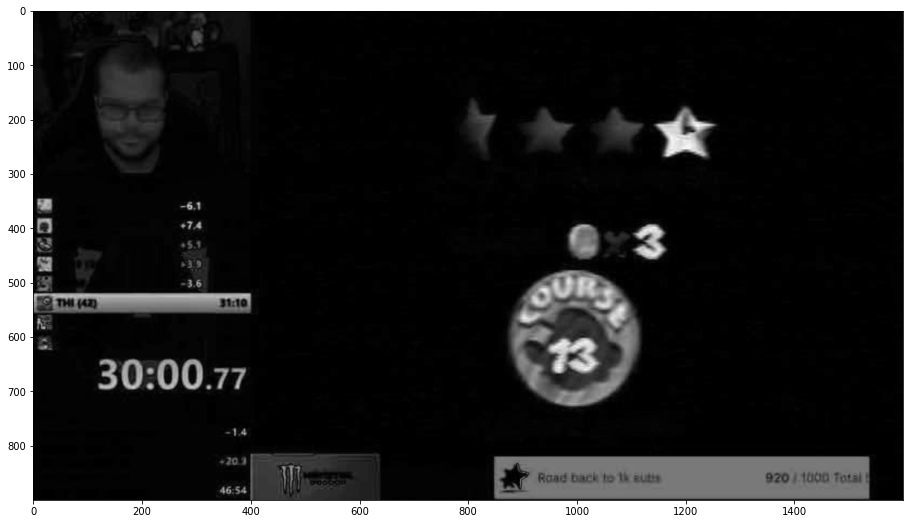

In [231]:
b,g,r = cv.split(img)

fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(np.std(img, axis=2), cmap='gray')

# pytesseract tests

In [18]:
import pytesseract

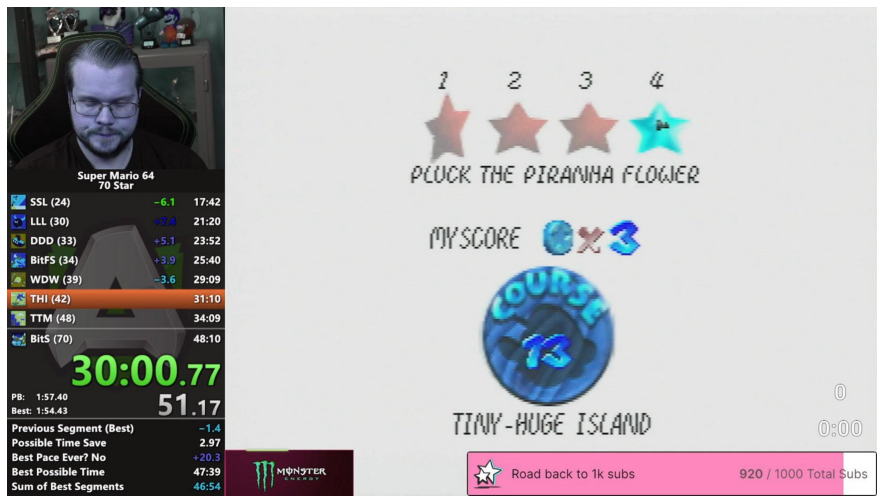

e

all!
Sy Mario 64
Star

fi ssi (24)
YY LLL Go)
43 DDD (33)
(he BitFs (34)
‘@) WDW (39)
BS THI (42)

oe Bits (70)

Previous Segment (Best)

Possible Time Save

Best Pace Ever? No

Best Possible Time if Wi MONSTER
Sum of Best Segments

I
:
sz

a Oi

TY-HUbE [Stal

ry

L

THE PIRAANA FLO

| Pie Road back to 1k subs

920 / 1000 Total Subs




In [29]:
show_img([img])
print(pytesseract.image_to_string(img))

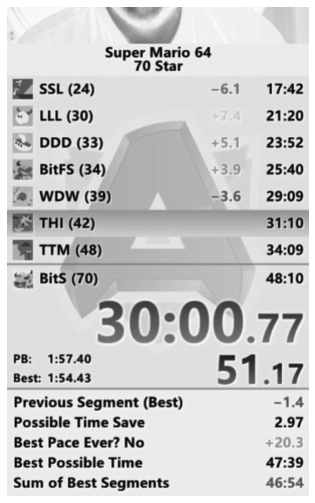

Super Mario 64
70 Star

WW ssi (24) -6.1 17:42
© LLL (30) 21:20
%< DDD (33) +5.1 23:52
‘Se BitFS (34) +3.9 25:40
‘@. WDW (39) -3.6 29:09
THI (42) 31:10
3 1 (48) 34:09
oi Bits (70) 48:10
@
30:00.77
PB: 1:57.40 1
Best: 1:54.43 5 1 7
Previous Segment (Best) -1.4
Possible Time Save 2.97
Best Pace Ever? No +20.3
Best Possible Time 47:39

Sum of Best Segments 46:54



In [248]:
scale=2
_im2 = cv.resize(cv.bitwise_not(to_grayscale(img[250:,:400])), dsize=None, fx=scale, fy=scale)
show_img([_im2])
print(pytesseract.image_to_string(_im2))